In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0628/weights_KD_segformer_0628_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0628(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0628(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Position_Embedding_0628_teacher


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0944

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 537ms/step - loss: 0.0486
Average validation loss: 0.3462594747543335
4/4 [==============================] - 5s 548ms/step - loss: 0.0486 - val_loss: 0.3463
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 808ms/step - loss: 0.0263 - val_loss: 0.3463
Average validation loss: 0.22804220020771027
4/4 [==============================] - 9s 821ms/step - loss: 0.0263 - val_loss: 0.2872
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 779ms/step - loss: 0.0178 - val_loss: 0.2872
Average validation loss: 0.16563788056373596
4/4 [==============================] - 12s 797ms/step - loss: 0.0178 - val_lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 688ms/step - loss: 3.8192e-05
Average validation loss: 4.277558582543861e-05
8/8 [==============================] - 6s 698ms/step - loss: 3.8192e-05 - val_loss: 4.2776e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 688ms/step - loss: 3.7629e-05 - val_loss: 4.2776e-05
Average validation loss: 1.9150766092934646e-05
8/8 [==============================] - 11s 697ms/step - loss: 3.7629e-05 - val_loss: 3.0963e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 697ms/step - loss: 3.7266e-05 - val_loss: 3.0963e-05
Average validation loss: 0.00019610765593824908
8/8 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 697ms/step - loss: 6.4611e-05
Average validation loss: 0.021738120267400518
12/12 [==============================] - 8s 709ms/step - loss: 6.4611e-05 - val_loss: 0.0217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 704ms/step - loss: 6.3558e-05 - val_loss: 0.0217
Average validation loss: 0.037994168077905975
12/12 [==============================] - 17s 713ms/step - loss: 6.3558e-05 - val_loss: 0.0299
Epoch 3/10
12/12 [==============================] - 25s 690ms/step - loss: 6.4020e-05 - val_loss: 0.0299
Average validation loss: 0.044583013507993506
12/12 [==============================] - 25s 700ms/step - loss: 6.4020e-05 - val_loss: 0.0348
Epoch 4/10
12/12 [==============================] - 34s 691ms/step - loss: 6.2184e-05 - val_loss: 0.0348
Average validati

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 709ms/step - loss: 5.0668e-05
Average validation loss: 0.028764152550138533
16/16 [==============================] - 12s 720ms/step - loss: 5.0668e-05 - val_loss: 0.0288
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 685ms/step - loss: 5.0782e-05 - val_loss: 0.0288
Average validation loss: 0.05909651665524507
16/16 [==============================] - 23s 696ms/step - loss: 5.0782e-05 - val_loss: 0.0439
Epoch 3/10
16/16 [==============================] - 34s 687ms/step - loss: 4.8206e-05 - val_loss: 0.0439
Average validation loss: 0.0631701724978484
16/16 [==============================] - 34s 698ms/step - loss: 4.8206e-05 - val_loss: 0.0503
Epoch 4/10
16/16 [==============================] - 45s 691ms/step - loss: 4.7354e-05 - val_loss: 0.0503
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 699ms/step - loss: 4.4585e-05
Average validation loss: 0.02241805624216795
20/20 [==============================] - 14s 710ms/step - loss: 4.4585e-05 - val_loss: 0.0224
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 683ms/step - loss: 3.1070e-05 - val_loss: 0.0224
Average validation loss: 0.03797547992435284
20/20 [==============================] - 28s 694ms/step - loss: 3.1070e-05 - val_loss: 0.0302
Epoch 3/10
20/20 [==============================] - 42s 685ms/step - loss: 2.5261e-05 - val_loss: 0.0302
Average validation loss: 0.06721423484559637
20/20 [==============================] - 42s 695ms/step - loss: 2.5261e-05 - val_loss: 0.0425
Epoch 4/10
20/20 [==============================] - 56s 686ms/step - loss: 2.1445e-05 - val_loss: 0.0425
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 705ms/step - loss: 5.0697e-05
Average validation loss: 0.030568798693517845
24/24 [==============================] - 17s 715ms/step - loss: 5.0697e-05 - val_loss: 0.0306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 689ms/step - loss: 3.4362e-05 - val_loss: 0.0306
Average validation loss: 0.02924875821918249
24/24 [==============================] - 34s 698ms/step - loss: 3.4362e-05 - val_loss: 0.0299
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 50s 689ms/step - loss: 2.6328e-05 - val_loss: 0.0299
Average validation loss: 0.04796539557476839
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 690ms/step - loss: 1.2315e-04
Average validation loss: 0.14116496741771697
40/40 [==============================] - 28s 700ms/step - loss: 1.2315e-04 - val_loss: 0.1412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 681ms/step - loss: 1.0347e-04 - val_loss: 0.1412
Average validation loss: 0.1008134938776493
40/40 [==============================] - 56s 691ms/step - loss: 1.0347e-04 - val_loss: 0.1210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 83s 691ms/step - loss: 8.7286e-05 - val_loss: 0.1210
Average validation loss: 0.09593080282211304
40/40 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 693ms/step - loss: 5.2888e-05
Average validation loss: 0.03689912043046206
48/48 [==============================] - 34s 704ms/step - loss: 5.2888e-05 - val_loss: 0.0369
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 692ms/step - loss: 3.4843e-05 - val_loss: 0.0369
Average validation loss: 0.03133297288635125
48/48 [==============================] - 68s 702ms/step - loss: 3.4843e-05 - val_loss: 0.0341
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 101s 694ms/step - loss: 3.0749e-05 - val_loss: 0.0341
Average validation loss: 0.039594699357015394
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 684ms/step - loss: 6.9348e-05
Average validation loss: 0.06028773494212406
56/56 [==============================] - 39s 694ms/step - loss: 6.9348e-05 - val_loss: 0.0603
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 77s 690ms/step - loss: 5.0080e-05 - val_loss: 0.0603
Average validation loss: 0.06250511474380412
56/56 [==============================] - 78s 700ms/step - loss: 5.0080e-05 - val_loss: 0.0614
Epoch 3/10
56/56 [==============================] - 116s 682ms/step - loss: 3.9130e-05 - val_loss: 0.0614
Average validation loss: 0.03723115325140368
56/56 [==============================] - 117s 692ms/step - loss: 3.9130e-05 - val_loss: 0.0533
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 737ms/step - loss: 3.3329e-05
Average validation loss: 0.06293077674445158
64/64 [==============================] - 48s 748ms/step - loss: 3.3329e-05 - val_loss: 0.0629
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 731ms/step - loss: 2.6951e-05 - val_loss: 0.0629
Average validation loss: 0.0292566372663714
64/64 [==============================] - 95s 741ms/step - loss: 2.6951e-05 - val_loss: 0.0461
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 142s 731ms/step - loss: 2.3041e-05 - val_loss: 0.0461
Average validation loss: 0.02221219497732818
64/64 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 732ms/step - loss: 3.6535e-05
Average validation loss: 0.03467061810402407
72/72 [==============================] - 54s 743ms/step - loss: 3.6535e-05 - val_loss: 0.0347
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 106s 733ms/step - loss: 2.6376e-05 - val_loss: 0.0347
Average validation loss: 0.047775505731503166
72/72 [==============================] - 107s 743ms/step - loss: 2.6376e-05 - val_loss: 0.0412
Epoch 3/10
72/72 [==============================] - 160s 731ms/step - loss: 2.0277e-05 - val_loss: 0.0412
Average validation loss: 0.039366091342849865
72/72 [==============================] - 161s 742ms/step - loss: 2.0277e-05 - val_loss: 0.0406
Epoch 4/10
72/72 [==============================] - 213s 732ms/step - loss: 1.6891e-05 - val_loss: 0.0406
Average va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 55s 687ms/step - loss: 4.6471e-05
Average validation loss: 0.06437656823545694
80/80 [==============================] - 56s 697ms/step - loss: 4.6471e-05 - val_loss: 0.0644
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 111s 687ms/step - loss: 3.0933e-05 - val_loss: 0.0644
Average validation loss: 0.039121464965865015
80/80 [==============================] - 111s 697ms/step - loss: 3.0933e-05 - val_loss: 0.0517
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 167s 691ms/step - loss: 2.3203e-05 - val_loss: 0.0517
Average validation loss: 0.0372479033190757
80/80 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 66s 691ms/step - loss: 6.2296e-05
Average validation loss: 0.08495097199026229
96/96 [==============================] - 67s 701ms/step - loss: 6.2296e-05 - val_loss: 0.0850
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 130s 656ms/step - loss: 4.0719e-05 - val_loss: 0.0850
Average validation loss: 0.08701027458967776
96/96 [==============================] - 131s 666ms/step - loss: 4.0719e-05 - val_loss: 0.0860
Epoch 3/10
96/96 [==============================] - 195s 663ms/step - loss: 3.3040e-05 - val_loss: 0.0860
Average validation loss: 0.08635319532853221
96/96 [==============================] - 196s 673ms/step - loss: 3.3040e-05 - val_loss: 0.0861
Epoch 4/10
96/96 [==============================] - 259s 656ms/step - loss: 2.6828e-05 - val_loss: 0.0861
Average val

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 83s 689ms/step - loss: 3.6910e-05
Average validation loss: 0.06528550529037602
120/120 [==============================] - 84s 699ms/step - loss: 3.6910e-05 - val_loss: 0.0653
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 167s 691ms/step - loss: 2.4490e-05 - val_loss: 0.0653
Average validation loss: 0.05015780881027846
120/120 [==============================] - 168s 701ms/step - loss: 2.4490e-05 - val_loss: 0.0577
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 250s 684ms/step - loss: 2.0834e-05 - val_loss: 0.0577
Average validation loss: 0.04954370851822508
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 99s 684ms/step - loss: 2.4810e-05
Average validation loss: 0.0816576077325711
144/144 [==============================] - 100s 694ms/step - loss: 2.4810e-05 - val_loss: 0.0817
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 199s 684ms/step - loss: 1.9517e-05 - val_loss: 0.0817
Average validation loss: 0.025754472580350313
144/144 [==============================] - 200s 694ms/step - loss: 1.9517e-05 - val_loss: 0.0537
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 298s 683ms/step - loss: 1.8282e-05 - val_loss: 0.0537
Average validation loss: 0.08826024342751124
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 109s 684ms/step - loss: 1.4488e-05
Average validation loss: 0.23911289396428836
160/160 [==============================] - 111s 694ms/step - loss: 1.4488e-05 - val_loss: 0.2391
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 220s 681ms/step - loss: 1.0189e-05 - val_loss: 0.2391
Average validation loss: 0.04571590341706724
160/160 [==============================] - 222s 691ms/step - loss: 1.0189e-05 - val_loss: 0.1424
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 331s 682ms/step - loss: 8.7065e-06 - val_loss: 0.1424
Average validation loss: 0.04220121231101075
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 137s 685ms/step - loss: 6.4091e-05
Average validation loss: 0.20604503929144777
200/200 [==============================] - 139s 695ms/step - loss: 6.4091e-05 - val_loss: 0.2060
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 276s 682ms/step - loss: 4.5075e-05 - val_loss: 0.2060
Average validation loss: 0.1271902791139314
200/200 [==============================] - 277s 692ms/step - loss: 4.5075e-05 - val_loss: 0.1666
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 414s 684ms/step - loss: 3.4777e-05 - val_loss: 0.1666
Average validation loss: 0.12917165638815276
200/200 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:52 - loss: 5.9439e-06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 164s 683ms/step - loss: 3.3348e-05
Average validation loss: 0.09441000332944896
240/240 [==============================] - 166s 694ms/step - loss: 3.3348e-05 - val_loss: 0.0944
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 330s 681ms/step - loss: 2.2731e-05 - val_loss: 0.0944
Average validation loss: 0.0862527230071881
240/240 [==============================] - 332s 691ms/step - loss: 2.2731e-05 - val_loss: 0.0903
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 496s 681ms/step - loss: 1.7738e-05 - val_loss: 0.0903
Average validation loss: 0.13333702820386956
240/240 [===============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.03701906749465593, 0.03785599638451231, 0.08885616975258089, 0.07071416283818906, 0.04132830899476949, 0.03961130374649732, 0.06537207537978929, 0.03571901864327325, 0.03258746567632833, 0.03868941045796419, 0.048101483830108115, 0.04837169604036341, 0.061379539889533506, 0.07304527064430962, 0.079776489868839, 0.08389531397542858, 0.08832755909099678, 0.1051090519374449]
std_val_losses =  [0.06478139025091426, 0.02995092675102289, 0.05425771491709951, 0.028199056142794703, 0.018097077360828114, 0.015181265966822557, 0.03395312719546519, 0.013546549435482568, 0.01356996333766896, 0.019647717429098276, 0.024959572914196645, 0.01468563146404489, 0.020141943742074002, 0.022592011111311566, 0.0838918835669988, 0.06299019434441958, 0.038663669823476306, 0.033541026678874854]


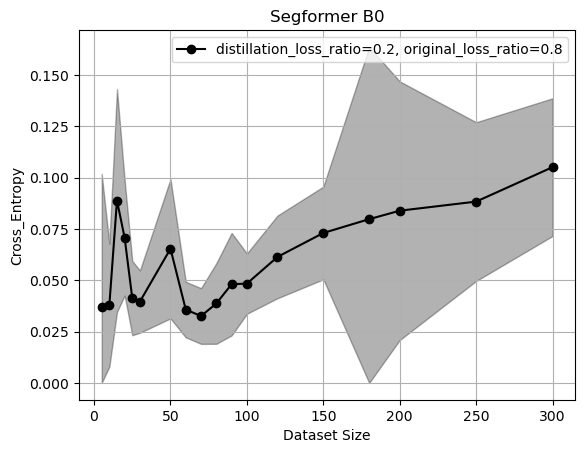

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0628')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.png"))

plt.show()